# 0. Setup

In [2]:
import nilearn
import pandas as pd
import numpy as np
import os

from nilearn import plotting
from nilearn import connectome



In [8]:
# Set the path to the data directory
src_dir = '../data/'

# Set the participant and session IDs
part_id = 'sub-01'
ses_id = 'ses-01'

# Path to the T1w image
anat_path = os.path.join(src_dir, part_id, ses_id, 'anat', f'{part_id}_{ses_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')

# Path to functional image
funcdir_path = os.path.join(src_dir, part_id, ses_id, 'func')

## 0.1 Anat

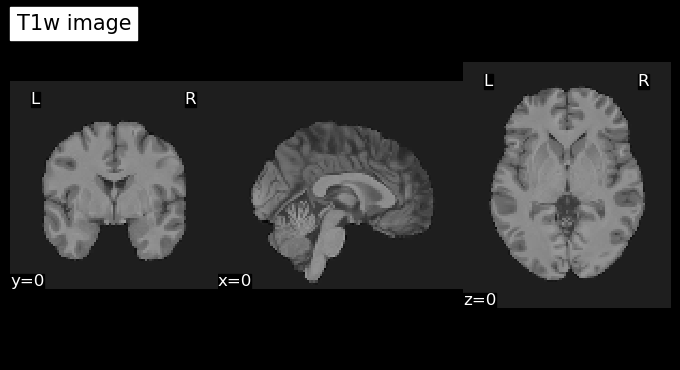

In [11]:
from nilearn.plotting import plot_anat

plot_anat(anat_path, title='T1w image', display_mode='ortho',  draw_cross=False,  cut_coords=(0, 0, 0))


# 1. Load Mask / atlas / meta

# 2. Extract timecourses per ROI / block

# 3. Compute connectivity

# 4. Compare emotions and save